# 1. データの読み込みと確認

In [89]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# 日本語フォントの設定（環境に合わせて変更してください）
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_columns', 50) # 表示する列数を増やす

In [90]:
# データを読み込む

df = pd.read_csv('data/suumo_data.csv')

# データの最初の5行を表示
df.head()

,building_name,address,transportation_1,transportation_2,transportation_3,age,floors,rent,admin_fee,deposit,gratuity,layout,area
0,ディームス大手町ノース,東京都千代田区神田多町２,ＪＲ山手線/神田駅 歩4分,東京メトロ丸ノ内線/淡路町駅 歩4分,東京メトロ千代田線/新御茶ノ水駅 歩6分,築6年,地下1地上12階建,16.4,10000,16.4,16.4,1DK,27.02
1,ディームス大手町ノース,東京都千代田区神田多町２,ＪＲ山手線/神田駅 歩4分,東京メトロ丸ノ内線/淡路町駅 歩4分,東京メトロ千代田線/新御茶ノ水駅 歩6分,築6年,地下1地上12階建,17.7,10000,17.7,17.7,1DK,28.34
2,ディームス大手町ノース,東京都千代田区神田多町２,ＪＲ山手線/神田駅 歩4分,東京メトロ丸ノ内線/淡路町駅 歩4分,東京メトロ千代田線/新御茶ノ水駅 歩6分,築6年,地下1地上12階建,18.0,10000,18.0,18.0,1DK,28.34
3,ディームス大手町ノース,東京都千代田区神田多町２,ＪＲ山手線/神田駅 歩4分,東京メトロ丸ノ内線/淡路町駅 歩4分,東京メトロ千代田線/新御茶ノ水駅 歩6分,築6年,地下1地上12階建,28.3,15000,28.3,28.3,2LDK,50.03
4,ディームス大手町ノース,東京都千代田区神田多町２,ＪＲ山手線/神田駅 歩4分,東京メトロ丸ノ内線/淡路町駅 歩4分,東京メトロ千代田線/新御茶ノ水駅 歩6分,築6年,地下1地上12階建,29.5,15000,29.5,29.5,2LDK,50.03


In [83]:
df["layout"].unique()

array(['1DK', '2LDK', '1LDK', '3LDK', 'ワンルーム', '1K', '3DK', '2SLDK',
       '2DK', '2SDK', '1SDK', '1SLDK', '2K'], dtype=object)

# 2. データ前処理

収集したデータを機械学習で扱えるように、数値データに変換したり、不要な文字列を削除したりします。

In [92]:
def preprocess(df):
    # コピーを作成して元のDataFrameを変更しないようにする
    df_processed = df.copy()

    # 1. 築年数 (age) から数値（年数）を抽出
    df_processed['age_years'] = df_processed['age'].str.extract(r'(\d+)').astype(float)
    # 新築の場合は0年とする
    df_processed.loc[df_processed['age'] == '新築', 'age_years'] = 0

    # 2. 建物階数 (floors) から数値（地上階数）を抽出
    df_processed['total_floors'] = df_processed['floors'].str.extract(r'(\d+)階建').astype(float)

    # 3. 交通アクセス (transportation) から駅徒歩分数を抽出 (最も近いもの)
    # '歩'の前の数字を抽出する正規表現
    walk_minutes = df_processed['transportation_1'].str.extract(r'歩(\d+)分').astype(float)
    df_processed['walk_minutes'] = walk_minutes

    # 4. 面積 (area) を数値に変換
    df_processed['area_m2'] = df_processed['area'].astype(float)

    # 5. 間取り (layout) をダミー変数に変換
    # L, D, K, S, R の有無で特徴量を作成
    df_processed['has_L'] = df_processed['layout'].str.contains('L').astype(int)
    df_processed['has_D'] = df_processed['layout'].str.contains('D').astype(int)
    df_processed['has_K'] = df_processed['layout'].str.contains('K').astype(int)
    df_processed['has_S'] = df_processed['layout'].str.contains('S').astype(int)
    df_processed['has_R'] = df_processed['layout'].str.contains('R').astype(int)
    # 間取りの部屋数を抽出
    df_processed['layout_rooms'] = df_processed['layout'].str.extract(r'(\d+)').astype(float)
    df_processed['layout_rooms'].fillna(1, inplace=True) # 1K, 1Rなどは1部屋とする

    # 6. 不要な列を削除
    df_processed = df_processed.drop([
        'building_name', 'address', 'transportation_1', 'transportation_2', 
        'transportation_3', 'age', 'floors', 'layout', 'area'
    ], axis=1)

    # 7. 欠損値の処理 (ここでは簡単のため中央値で埋める)
    for col in ['age_years', 'total_floors', 'walk_minutes']:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)
        
    return df_processed

df_clean = preprocess(df)

print("前処理後のデータ:")
df_clean.head()

前処理後のデータ:


,rent,admin_fee,deposit,gratuity,age_years,total_floors,walk_minutes,area_m2,has_L,has_D,has_K,has_S,has_R,layout_rooms
0,16.4,10000,16.4,16.4,6.0,12.0,4.0,27.02,0,1,1,0,0,1.0
1,17.7,10000,17.7,17.7,6.0,12.0,4.0,28.34,0,1,1,0,0,1.0
2,18.0,10000,18.0,18.0,6.0,12.0,4.0,28.34,0,1,1,0,0,1.0
3,28.3,15000,28.3,28.3,6.0,12.0,4.0,50.03,1,1,1,0,0,2.0
4,29.5,15000,29.5,29.5,6.0,12.0,4.0,50.03,1,1,1,0,0,2.0


# 3. 探索的データ分析 (EDA)

前処理したデータを使って、家賃と各特徴量の関係を可視化し、理解を深めます。

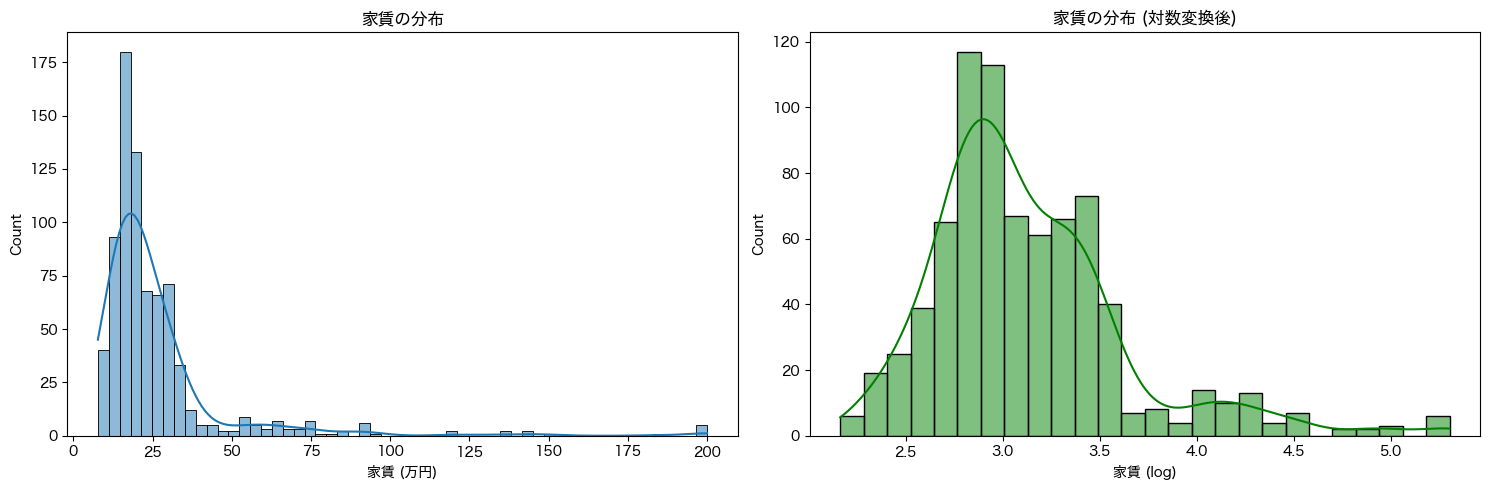

In [103]:
plt.figure(figsize=(15, 5))

# 家賃のヒストグラム
plt.subplot(1, 2, 1)
sns.histplot(df_clean['rent'], kde=True)
plt.title('家賃の分布')
plt.xlabel('家賃 (万円)')

# 家賃（対数変換後）のヒストグラム
# モデルの精度向上のため、目的変数を正規分布に近づける
df_clean['rent_log'] = np.log1p(df_clean['rent'])
plt.subplot(1, 2, 2)
sns.histplot(df_clean['rent_log'], kde=True, color='green')
plt.title('家賃の分布 (対数変換後)')
plt.xlabel('家賃 (log)')

plt.tight_layout()
plt.show()

各特徴量と家賃の相関係数:
area_m2: 0.940
age_years: -0.009
walk_minutes: -0.078


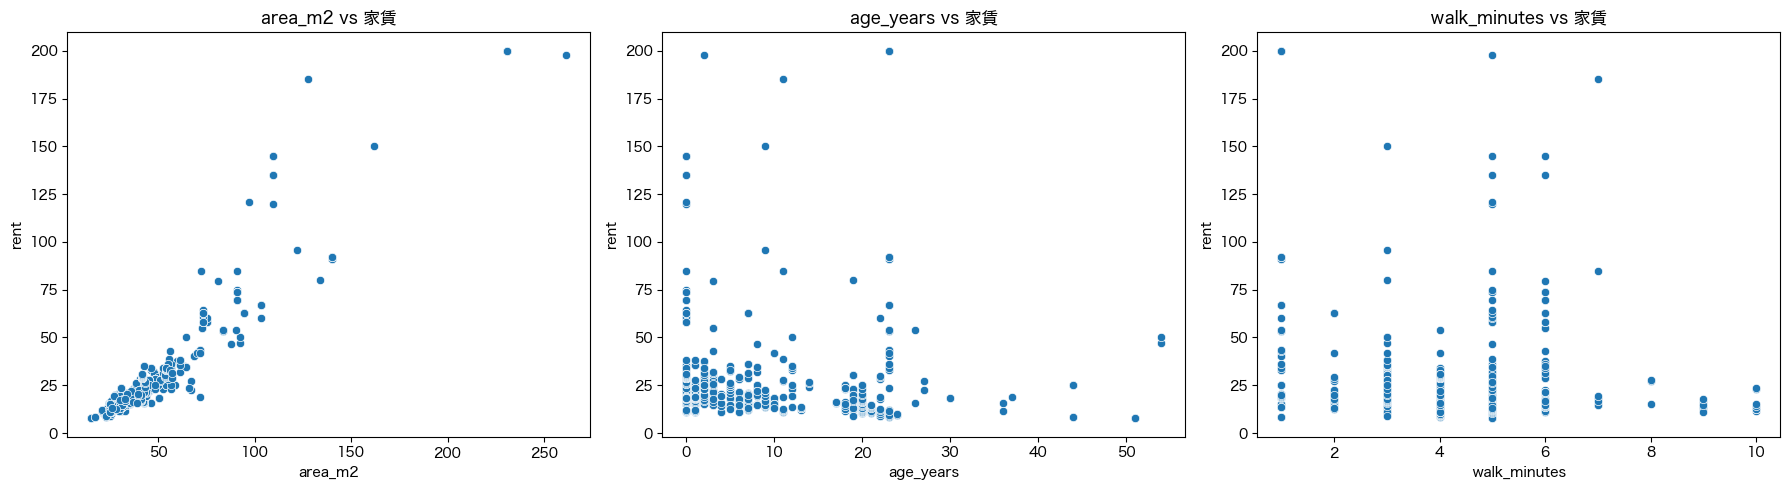

In [105]:
# 主要な特徴量と家賃の関係を可視化
features_to_plot = ['area_m2', 'age_years', 'walk_minutes']

plt.figure(figsize=(18, 5))

for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=df_clean[feature], y=df_clean['rent'])
    plt.title(f'{feature} vs 家賃')

# 各特徴量と家賃の相関係数を計算
print("各特徴量と家賃の相関係数:")
for feature in features_to_plot:
    correlation = df_clean[feature].corr(df_clean['rent'])
    print(f"{feature}: {correlation:.3f}")

plt.tight_layout()
plt.show()

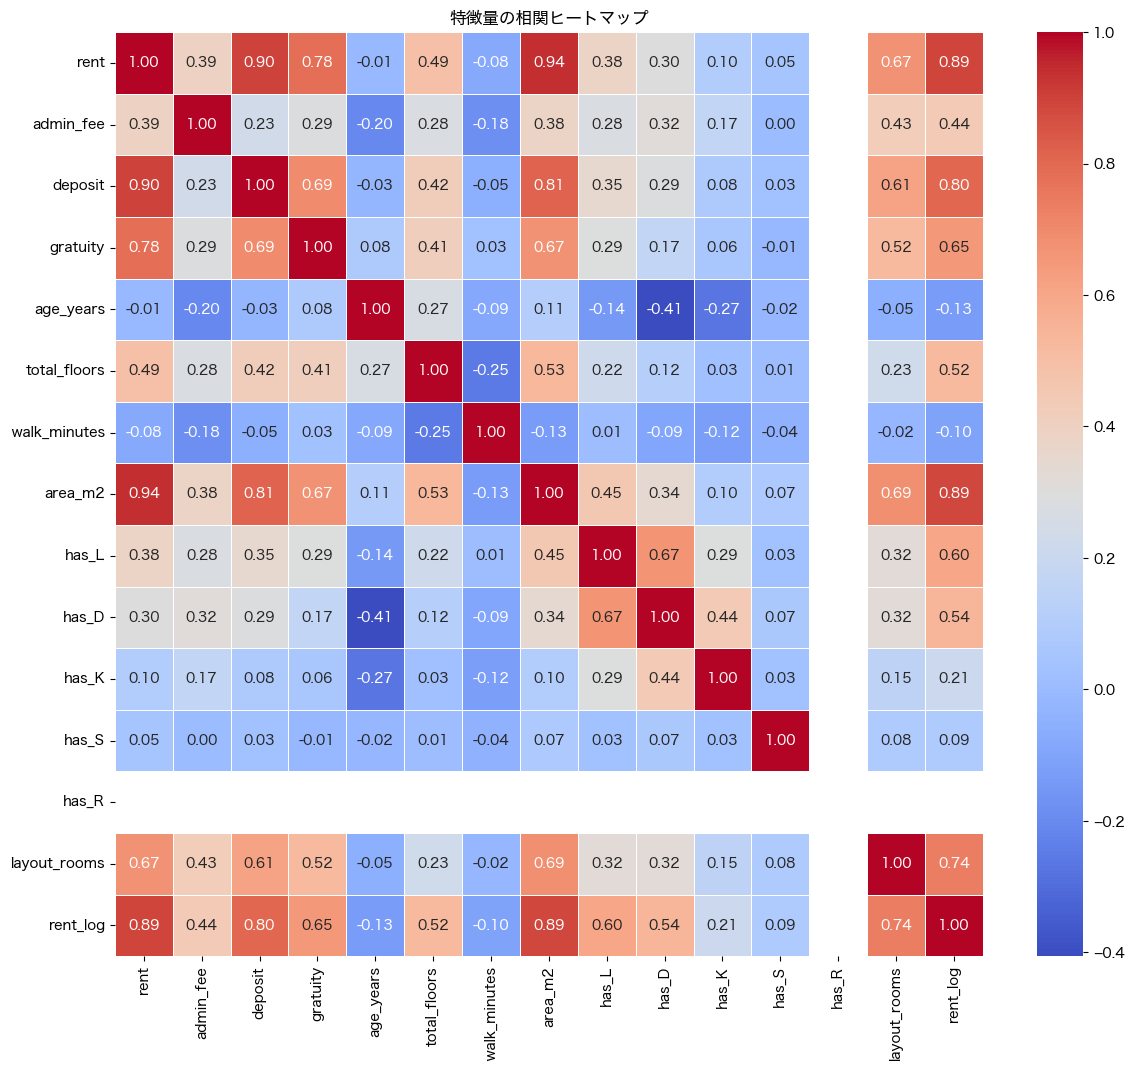

In [87]:
# 相関行列を計算
correlation_matrix = df_clean.corr()

# ヒートマップで可視化
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('特徴量の相関ヒートマップ')
plt.show()

# 4. 前処理済みデータの保存

In [88]:
# モデリング用のノートブックで使えるように、前処理済みのデータをCSVファイルとして保存します。
output_path = 'data/suumo_data_cleaned.csv'
df_clean.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f'Cleaned data saved to {output_path}')

Cleaned data saved to data/suumo_data_cleaned.csv
